# Assignments by Felix Vernieuwe

---
---

## Assignment 2: Feature Engineering
---
---

In [28]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from lightgbm.sklearn import LGBMRanker

from FelixVernieuwe.util import setup_seaborn

setup_seaborn()

In [3]:
# Load in the datasets
articles = pd.read_parquet("../../data/alt/articles.parquet")
customers = pd.read_parquet("../../data/alt/customers.parquet")
transactions = pd.read_parquet("../../data/alt/transactions_train.parquet")

In [17]:
reference_week = transactions["week"].max()

used_features = [
    'article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
    'perceived_colour_master_id', 'department_no', 'index_code',
    'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
    'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank'
]

---
## Feature Engineering
---

### Product features

#### Bestseller Ranking

In [5]:
# Add 'Bestseller' feature to the dataset
from bestseller_rank import bestseller_ranking

transactions, customers, articles = bestseller_ranking(transactions, customers, articles, reference_week)

C:\Users\Felix\PycharmProjects\ai-project-23-24\FelixVernieuwe\02 - Feature Engineering\bestseller_rank.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['bought'] = 1


In [6]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week,bought,bestseller_rank
259636,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0,12.0
259637,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0,999.0
259638,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0,999.0
259639,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0,999.0
259640,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0,999.0
...,...,...,...,...,...,...,...,...
18972161,2020-09-15,18446630855572834764,918292001,0.041424,2,104,0.0,8.0
18972162,2020-09-15,18446630855572834764,762846027,0.025104,2,104,0.0,9.0
18972163,2020-09-15,18446630855572834764,809238005,0.041656,2,104,0.0,10.0
18972164,2020-09-15,18446630855572834764,673677002,0.024925,2,104,0.0,11.0


---
## Training preparation
---

In [8]:
# Merge transactions data with article and customer information
data = transactions.copy()
data = data.merge(articles, on="article_id", how="left")
data = data.merge(customers, on="customer_id", how="left")

# Clean up incoming data
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
# Split up training and test datasets
is_reference = data["week"] == reference_week
train = data[~is_reference]
test = data[is_reference]

# Ensure that each article appears only once per customer
test = test.drop_duplicates(["customer_id", "article_id", "sales_channel_id"]).copy()

# Gives amount of items purchased per customer per week (used for training the ranking)
train_bins = train.groupby(["week", "customer_id"])["article_id"].count().values

In [18]:
# Train only on specified features 

train_X = train[used_features]
train_y = train["bought"]

test_X = test[used_features]

---
## Model Training
---

In [19]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_bins,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.845633
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.151086
[LightGBM] [Debug] init for col-wise cost 0.139103 seconds, init for row-wise cost 0.253365 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 11678480, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9


<AxesSubplot: xlabel='importance', ylabel='feature'>

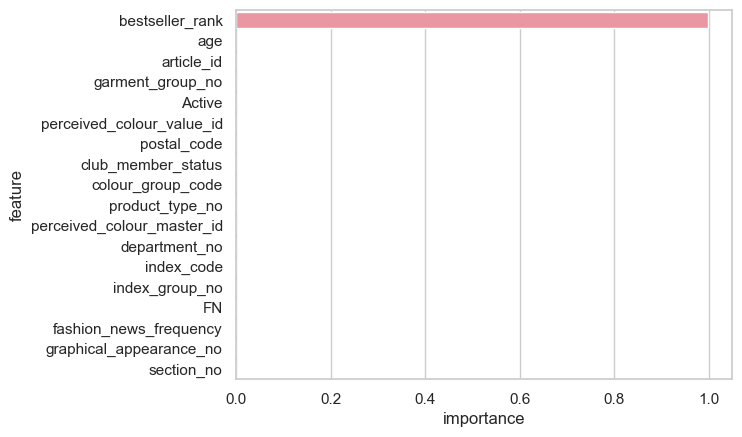

In [29]:
# Percentual importance of each feature
feature_importance = pd.DataFrame(
    {
        "feature": used_features,
        "importance": ranker.feature_importances_,
    }
).sort_values("importance", ascending=False)

feature_importance["importance"] = feature_importance["importance"] / feature_importance["importance"].sum()

sns.barplot(x="importance", y="feature", data=feature_importance)

---
## Predictions
---

In [ ]:
# Predict on test set
test_X["pred"] = ranker.predict(test_X)

# Per user, predict up to 12 articles
predicted_articles = test_X.groupby("customer_id").apply(
    lambda x: x.sort_values("pred", ascending=False).head(12)
)[["article_id"]].reset_index()

---
## Submission
---

In [ ]:
# Read in sample submission (customer_id, prediction)
submission = pd.read_csv("../../submissions/sample_submission.csv")

# Replace predictions with predictions from model
submission["prediction"] = predicted_articles["article_id"].apply(
    lambda x: " ".join(["0" + str(i) for i in x])
)

# Write submission to csv
submission.to_csv("../../submissions/engineered_0_submission.csv", index=False)